In [1]:
import os 
os.chdir('../src/')
print(os.getcwd())
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_analysis.d00_utils.load_confs import load_parameters

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
params = load_parameters()
pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src


Read in video level data

In [2]:
xml_paths = ["C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\15_2019-06-29_13-01-03.094068_00001.01252.xml",
            "C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\14_2019-06-29_13-01-19.744908_00001.05900.xml"]

video_level_dfs = pd.read_csv("../data/carolinetemp/video_level_df.csv",
                    dtype={"camera_id": str},
                    parse_dates=["video_upload_datetime"])
del video_level_dfs['Unnamed: 0']

video_level_df_list = []
video_level_groups = video_level_dfs.groupby(['camera_id', 'video_upload_datetime'])
for name, group in video_level_groups: 
    video_level_df_list.append(group)

Read in frame level data

In [3]:
frame_level_dfs = pd.read_csv("../data/carolinetemp/frame_level_df.csv",
                    dtype={"camera_id": str},
                    converters={"bboxes": lambda x: [float(coord) for coord in x.strip("[]").split(", ")]}, 
                    parse_dates=["video_upload_datetime"])
del frame_level_dfs['Unnamed: 0']

frame_level_df_list = []
frame_level_groups = frame_level_dfs.groupby(['camera_id', 'video_upload_datetime'])
for name, group in frame_level_groups: 
    frame_level_df_list.append(group)


Run evaluators

In [4]:
chunk_evaluator = ChunkEvaluator(annotation_xml_paths=xml_paths,
                                 params=params,
                                 video_level_dfs=video_level_df_list,
                                 frame_level_dfs = frame_level_df_list)
video_level_diff_df = chunk_evaluator.evaluate_video_level()
video_level_diff_df

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\single_evaluator.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.loc[len(df) + 1] = new_row_dict
C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\single_evaluator.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.loc[len(df) + 1] = new_row_dict


,camera_id,video_upload_datetime,vehicle_type,y_pred-y_counts,y_pred-y_starts,y_pred-y_stops,y_pred-y_parked
0,00001.01252,2019-06-29 13:01:03.094068,bus,0,0.0,0.0,0
1,00001.01252,2019-06-29 13:01:03.094068,car,3,0.0,3.0,0
2,00001.01252,2019-06-29 13:01:03.094068,motorbike,-2,0.0,0.0,0
3,00001.01252,2019-06-29 13:01:03.094068,truck,-1,0.0,0.0,0
0,00001.05900,2019-06-29 13:01:19.744908,bus,0,-1.0,-1.0,0
1,00001.05900,2019-06-29 13:01:19.744908,car,-2,3.0,-1.0,0
2,00001.05900,2019-06-29 13:01:19.744908,motorbike,-2,0.0,0.0,0
3,00001.05900,2019-06-29 13:01:19.744908,truck,-2,0.0,0.0,0


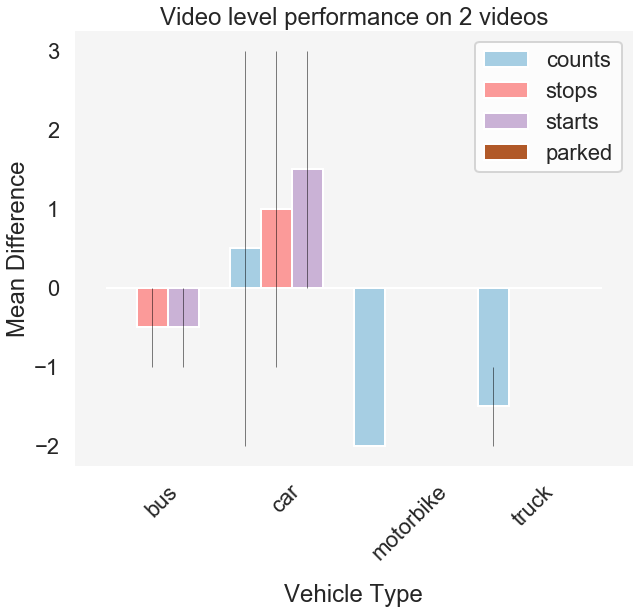

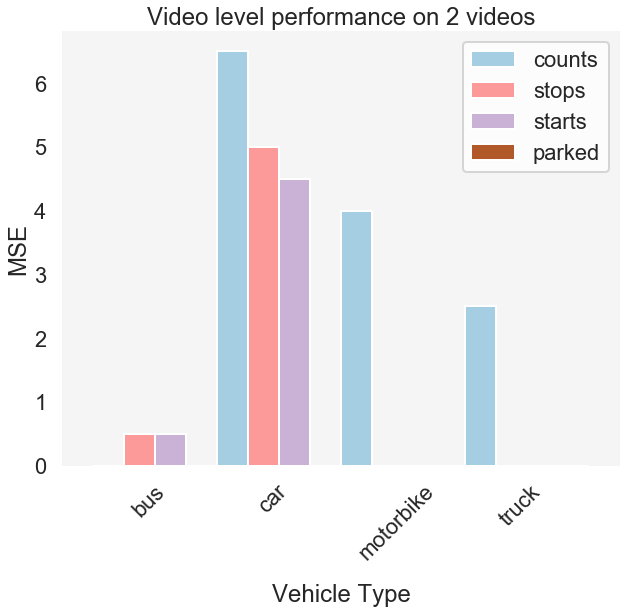

In [7]:
def plot_video_level_stats(video_level_diff_df: pd.DataFrame, 
                           metrics = {'mean_diff':None, 'mse':None},
                           show_plots = True): 
    
    n_videos = video_level_diff_df['n_videos'].iloc[0]
    
    if 'mean_diff' in metrics: 
        df = video_level_diff_df[video_level_diff_df["statistic"] != "mse"]
        mean_df = df[df['statistic'] == 'mean_diff'][['counts','stops','starts','parked','vehicle_type']].set_index('vehicle_type')
        sd_df = df[df['statistic'] == 'sd'][['counts','stops','starts','parked','vehicle_type']].set_index('vehicle_type').values.T

        ax = mean_df.plot(kind='bar',
                            yerr=sd_df,
                            grid=False,
                            figsize=(10,8),
                            position=0.45,
                            colormap = 'Paired',
                            error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )

        ax.set_facecolor('whitesmoke')

        for side in ax.spines:
            ax.spines[side].set_visible(False)

        plt.title(f"Video level performance on {n_videos} videos")
        plt.xticks(rotation=45)
        plt.xlabel("Vehicle Type", labelpad=20)
        plt.ylabel("Mean Difference")
        if show_plots: 
            plt.show()
        if metrics["mean_diff"] is not None: 
            plt.savefig(metrics["mean_diff"])
        plt.close()
        
    if 'mse' in metrics: 
        df = video_level_diff_df[video_level_diff_df["statistic"] == "mse"]
        mse_df = df[['counts','stops','starts','parked','vehicle_type']].set_index('vehicle_type')
        ax = mse_df.plot(kind='bar',
                            grid=False,
                            figsize=(10,8),
                            position=0.45,
                            colormap = 'Paired',
#                             error_kw=dict(ecolor='k',elinewidth=0.5),
                            width=1.0
                            )

        ax.set_facecolor('whitesmoke')

        for side in ax.spines:
            ax.spines[side].set_visible(False)

        plt.title(f"Video level performance on {n_videos} videos")
        plt.xticks(rotation=45)
        plt.xlabel("Vehicle Type", labelpad=20)
        plt.ylabel("MSE")
        if show_plots: 
            plt.show()
        if metrics["mse"] is not None: 
            plt.savefig(metrics["mse"])
        plt.close()
    return

plot_video_level_stats(video_level_diff_df, 
                       metrics = {'mean_diff':"../data/plots/video_mean.pdf",
                                  'mse':"../data/plots/video_mse.pdf"},
                       show_plots = True
                       )


Possible line chart for frame level

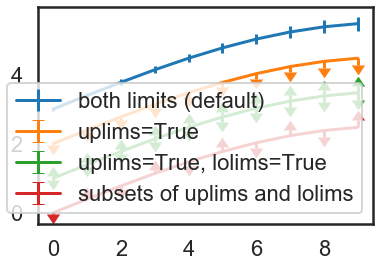

In [7]:
fig = plt.figure()
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)

#line1
plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')
#line2
plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')
#line3
plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
             label='uplims=True, lolims=True')
#line4
upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
             label='subsets of uplims and lolims')

plt.legend(loc='lower right')